In [1]:
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt

from mocksipipeline.util import read_data_cube
from mocksipipeline.modeling import convolve_with_response, project_spectral_cube
from astropy.wcs.utils import wcs_to_celestial_frame

from mocksipipeline.instrument.configuration import moxsi_cdr

import dask.array
import distributed

from astropy.visualization import ImageNormalize, LogStretch

In [2]:
spec_cube = read_data_cube(
    '/Users/wtbarnes/Documents/codes/mocksipipeline/pipeline/results/hic-ar-1h/spectral_cube.fits'
)

In [53]:
spec_cube.axis_world_coords(0)[0]

astropy.coordinates.spectral_coordinate.SpectralCoord

2024-06-05 23:14:59,152 - tornado.application - ERROR - Exception in callback <bound method SystemMonitor.update of <SystemMonitor: cpu: 3 memory: 1200 MB fds: 109>>
Traceback (most recent call last):
  File "/Users/wtbarnes/mambaforge/envs/mocksipipeline-dev/lib/python3.11/site-packages/tornado/ioloop.py", line 937, in _run
    val = self.callback()
          ^^^^^^^^^^^^^^^
  File "/Users/wtbarnes/mambaforge/envs/mocksipipeline-dev/lib/python3.11/site-packages/distributed/system_monitor.py", line 168, in update
    net_ioc = psutil.net_io_counters()
              ^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/wtbarnes/mambaforge/envs/mocksipipeline-dev/lib/python3.11/site-packages/psutil/__init__.py", line 2122, in net_io_counters
    rawdict = _psplatform.net_io_counters()
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
OSError: [Errno 12] Cannot allocate memory


In [3]:
slot_o1_channel = moxsi_cdr['spectrogram_slot_1']
slot_o4_channel = moxsi_cdr['spectrogram_slot_4']
pinhole_bethin_channel = moxsi_cdr.channel_list[3]

In [4]:
instr_cube = convolve_with_response(spec_cube, slot_o1_channel, include_gain=False)

/Users/wtbarnes/mambaforge/envs/mocksipipeline-dev/lib/python3.11/site-packages/astropy/units/equivalencies.py:141: RuntimeWarning: divide by zero encountered in divide
  (si.m, si.J, lambda x: hc / x),
/Users/wtbarnes/mambaforge/envs/mocksipipeline-dev/lib/python3.11/site-packages/xrt/backends/raycing/materials.py:253: UserWarning: Reading `.npy` or `.npz` file required additional header parsing as it was created on Python 2. Save the file again to speed up loading and avoid this warning.
  ef1f2 = (np.array(res[self.name+'_E']),
/Users/wtbarnes/mambaforge/envs/mocksipipeline-dev/lib/python3.11/site-packages/xrt/backends/raycing/materials.py:254: UserWarning: Reading `.npy` or `.npz` file required additional header parsing as it was created on Python 2. Save the file again to speed up loading and avoid this warning.
  np.array(res[self.name+'_f1']),
/Users/wtbarnes/mambaforge/envs/mocksipipeline-dev/lib/python3.11/site-packages/xrt/backends/raycing/materials.py:255: UserWarning: Readi

<WCSAxes: >

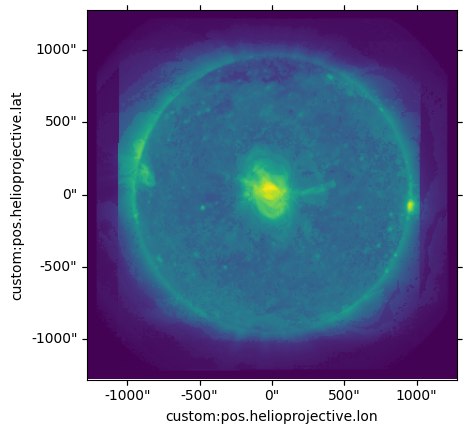

2024-06-05 20:48:59,660 - tornado.application - ERROR - Exception in callback <bound method SystemMonitor.update of <SystemMonitor: cpu: 3 memory: 1881 MB fds: 30>>
Traceback (most recent call last):
  File "/Users/wtbarnes/mambaforge/envs/mocksipipeline-dev/lib/python3.11/site-packages/tornado/ioloop.py", line 937, in _run
    val = self.callback()
          ^^^^^^^^^^^^^^^
  File "/Users/wtbarnes/mambaforge/envs/mocksipipeline-dev/lib/python3.11/site-packages/distributed/system_monitor.py", line 168, in update
    net_ioc = psutil.net_io_counters()
              ^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/wtbarnes/mambaforge/envs/mocksipipeline-dev/lib/python3.11/site-packages/psutil/__init__.py", line 2122, in net_io_counters
    rawdict = _psplatform.net_io_counters()
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
OSError: [Errno 12] Cannot allocate memory


In [17]:
instr_cube.rebin(instr_cube.data.shape[:1]+(1,1))[0].plot(norm=ImageNormalize(stretch=LogStretch()))

In [5]:
client = distributed.Client()

In [6]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 5
Total threads: 10,Total memory: 64.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:63432,Workers: 5
Dashboard: http://127.0.0.1:8787/status,Total threads: 10
Started: Just now,Total memory: 64.00 GiB
Comm: tcp://127.0.0.1:63450,Total threads: 2
Dashboard: http://127.0.0.1:63451/status,Memory: 12.80 GiB
Nanny: tcp://127.0.0.1:63435,


In [14]:
det_cube = project_spectral_cube(instr_cube,
                                 slot_o1_channel,
                                 #pinhole_bethin_channel,
                                 wcs_to_celestial_frame(spec_cube.wcs).observer,
                                 dt=1*u.s,
                                 interval=1*u.s,
                                 #chunks=(10,345,345),
                                 include_psf=True,
                                 include_charge_spreading=False,
                                 apply_gain_conversion=True,
                                 apply_electron_conversion=True)

/Users/wtbarnes/mambaforge/envs/mocksipipeline-dev/lib/python3.11/site-packages/distributed/client.py:3164: UserWarning: Sending large graph of size 126.51 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/Users/wtbarnes/mambaforge/envs/mocksipipeline-dev/lib/python3.11/site-packages/distributed/client.py:3164: UserWarning: Sending large graph of size 2.09 GiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/Users/wtbarnes/mambaforge/envs/mocksipipeline-dev/lib/python3.11/site-packages/astropy/units/equivalencies.py:141: RuntimeWarning: divide by zero encountered in divide
  (si.m, si.J, lambda x: hc / x),
  'angstrom' -> 'Angstrom'. [astropy.wcs.wcs]


In [113]:
from overlappy.io import read_overlappogram
from astropy.visualization import AsymmetricPercentileInterval

In [138]:
det_cube = read_overlappogram(
    '/Users/wtbarnes/Documents/codes/mocksipipeline/pipeline/results/cdr/ar_1h_jitter/detector_images/all_components.fits')

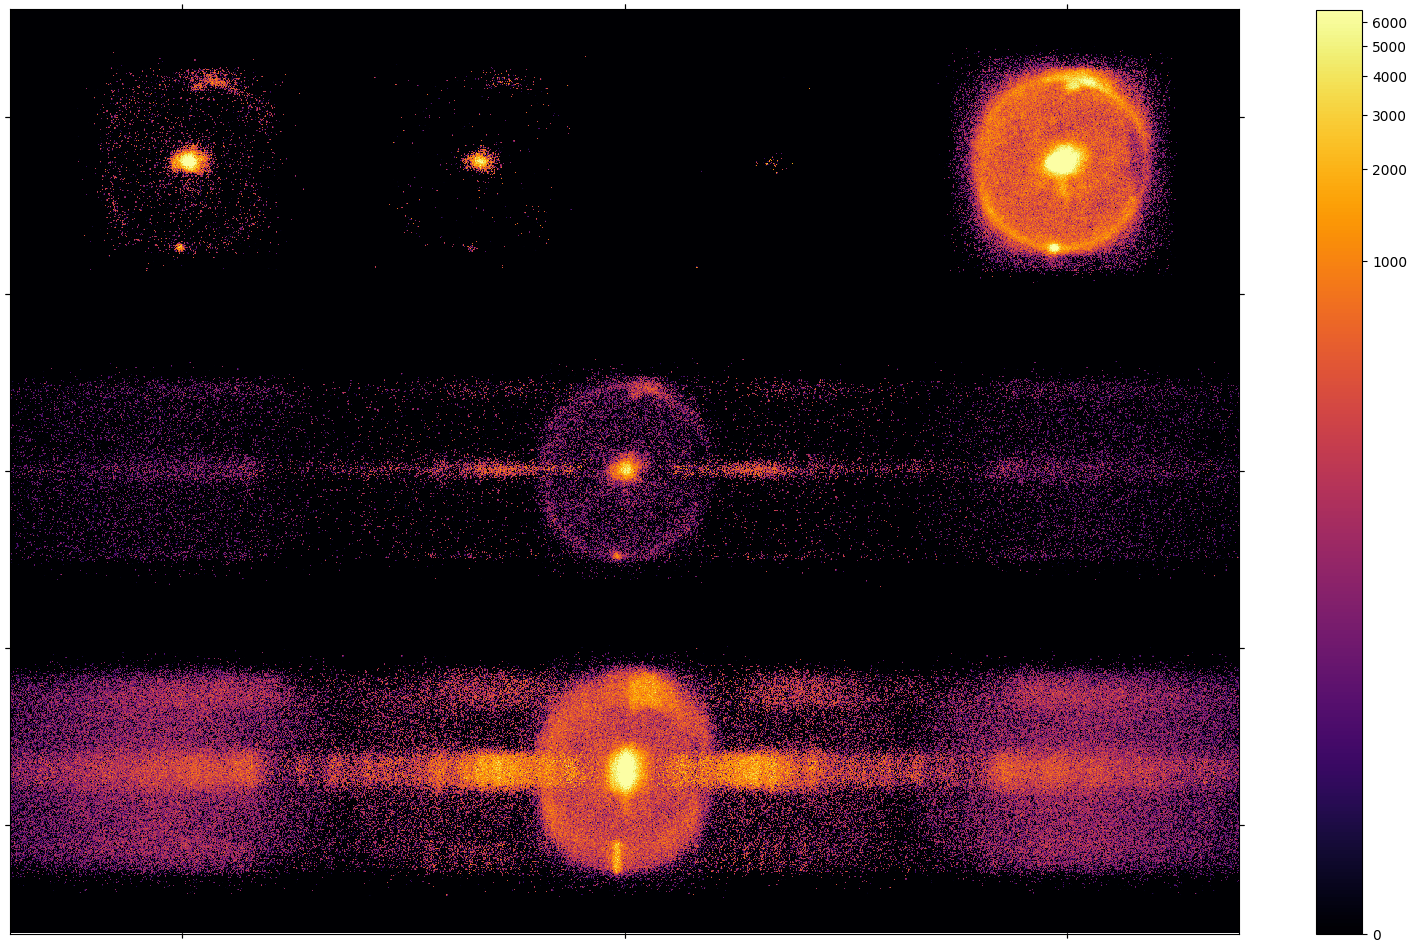

In [139]:
fig = plt.figure(figsize=(20,12))
ax = fig.add_subplot(projection=det_cube[0,:,:].wcs)
vmin,vmax = AsymmetricPercentileInterval(1,99.9).get_limits(det_cube[0,...].data)
det_cube[0,:,:].plot(
    norm=ImageNormalize(vmin=vmin,vmax=vmax,stretch=LogStretch()),
    axes=ax,interpolation='none',
    cmap='inferno')
plt.colorbar()

<WCSAxes: >

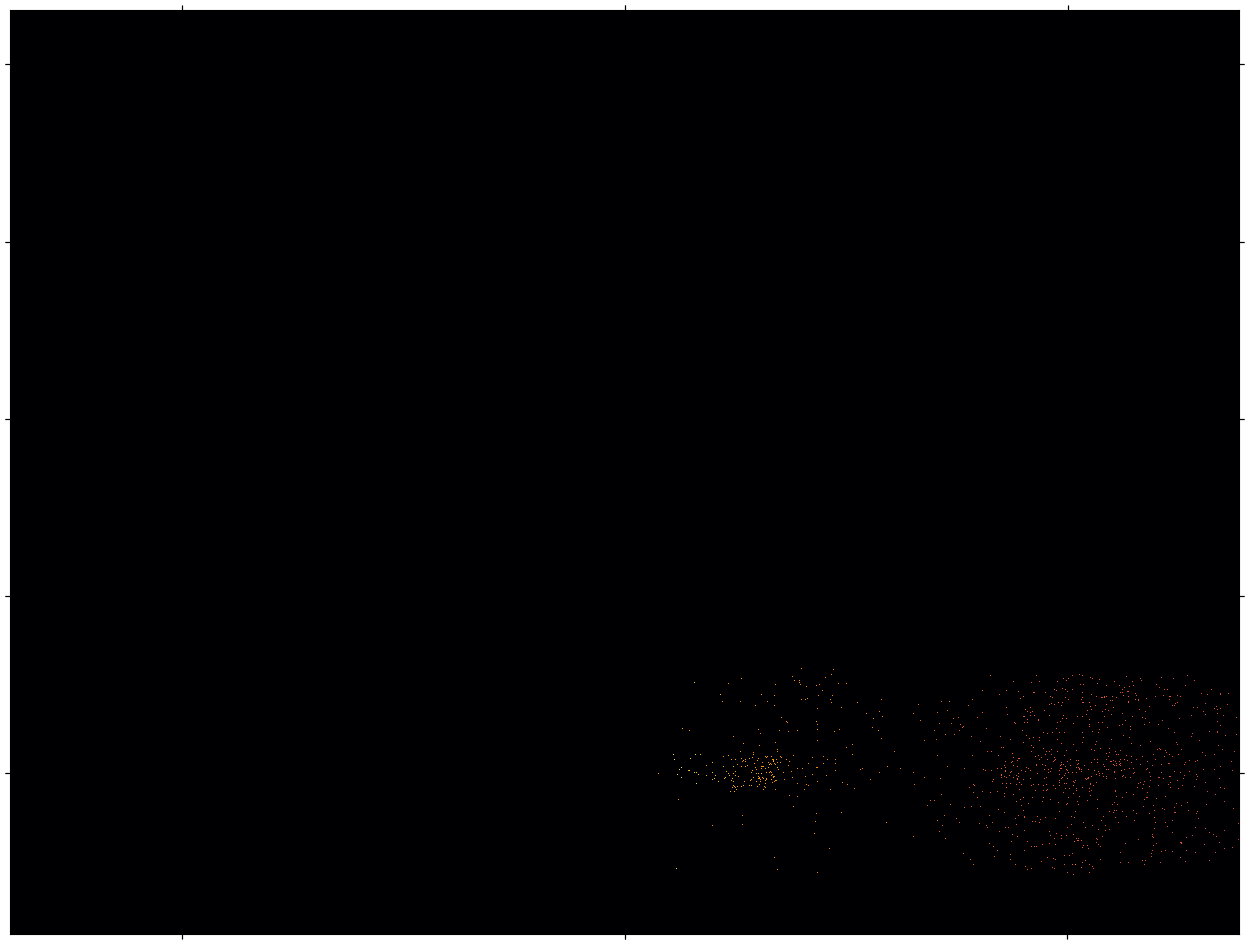

In [8]:
fig = plt.figure(figsize=(20,12))
ax = fig.add_subplot(projection=det_cube[0].wcs)
det_cube[0].plot(
    norm=ImageNormalize(stretch=LogStretch()),
    axes=ax,interpolation='none',
    cmap='inferno')

<WCSAxes: >

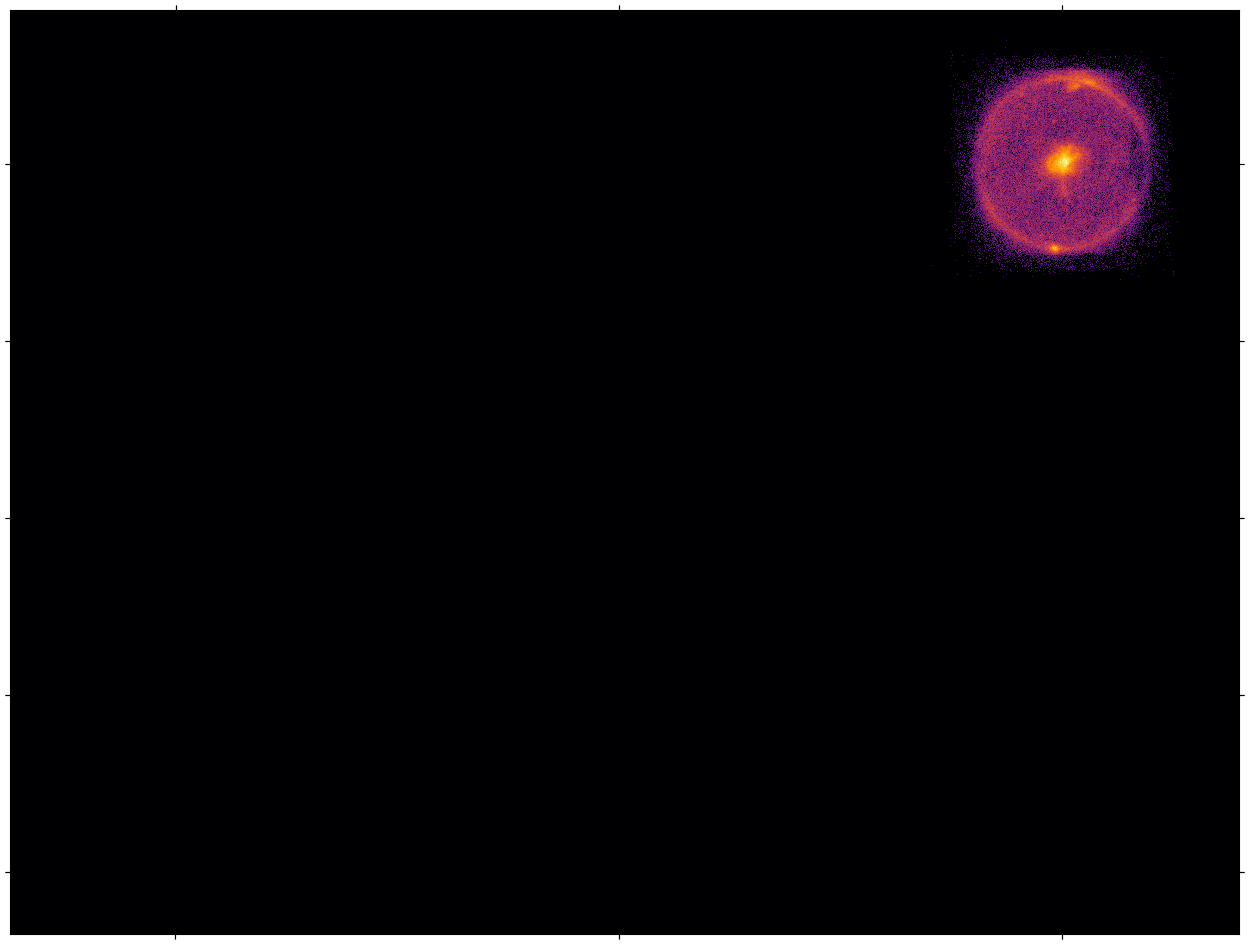

In [8]:
fig = plt.figure(figsize=(20,12))
ax = fig.add_subplot(projection=det_cube[0].wcs)
det_cube[0].plot(
    norm=ImageNormalize(stretch=LogStretch()),
    axes=ax,interpolation='none',
    cmap='inferno')

In [19]:
_psf_ = pinhole_bethin_channel.psf

In [21]:
_psf_.persist()

<xarray.DataArray (wavelength: 4, y: 418, x: 418)>
dask.array<open_dataset-__xarray_dataarray_variable__, shape=(4, 418, 418), dtype=float64, chunksize=(1, 418, 418), chunktype=numpy.ndarray>
Coordinates:
  * x              (x) float64 -207.8 -206.8 -205.8 -204.8 ... 207.2 208.2 209.2
  * y              (y) float64 -207.8 -206.8 -205.8 -204.8 ... 207.2 208.2 209.2
    delta_pixel_x  (x) float64 dask.array<chunksize=(418,), meta=np.ndarray>
    delta_pixel_y  (y) float64 dask.array<chunksize=(418,), meta=np.ndarray>
  * wavelength     (wavelength) float64 10.0 25.0 50.0 75.0

In [43]:
import sunpy.map
from astropy.coordinates import SkyCoord
from sunpy.coordinates import get_earth

In [23]:
m = sunpy.map.Map('/Users/wtbarnes/Documents/codes/mocksipipeline/pipeline/results/hic-ar-1h/level_2/aia_131.fits')

In [39]:
flare_loc = SkyCoord(Tx=-50*u.arcsec, Ty=75*u.arcsec, frame=m.coordinate_frame)

In [42]:
m.observer_coordinate

<SkyCoord (HeliographicStonyhurst: obstime=2018-07-14T15:00:00.000, rsun=695700.0 km): (lon, lat, radius) in (deg, deg, m)
    (0., 4.26851411, 1.52069147e+11)>

In [45]:
get_earth(m.date).radius.to('m')

<Distance 1.52069147e+11 m>

2024-06-05 21:34:06,597 - tornado.application - ERROR - Exception in callback <bound method SystemMonitor.update of <SystemMonitor: cpu: 10 memory: 15752 MB fds: 215>>
Traceback (most recent call last):
  File "/Users/wtbarnes/mambaforge/envs/mocksipipeline-dev/lib/python3.11/site-packages/tornado/ioloop.py", line 937, in _run
    val = self.callback()
          ^^^^^^^^^^^^^^^
  File "/Users/wtbarnes/mambaforge/envs/mocksipipeline-dev/lib/python3.11/site-packages/distributed/system_monitor.py", line 168, in update
    net_ioc = psutil.net_io_counters()
              ^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/wtbarnes/mambaforge/envs/mocksipipeline-dev/lib/python3.11/site-packages/psutil/__init__.py", line 2122, in net_io_counters
    rawdict = _psplatform.net_io_counters()
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
OSError: [Errno 12] Cannot allocate memory
2024-06-05 22:31:40,136 - tornado.application - ERROR - Exception in callback <bound method SystemMonitor.update of <SystemMonitor:

In [41]:
m.date.iso

'2018-07-14 15:00:00.000'

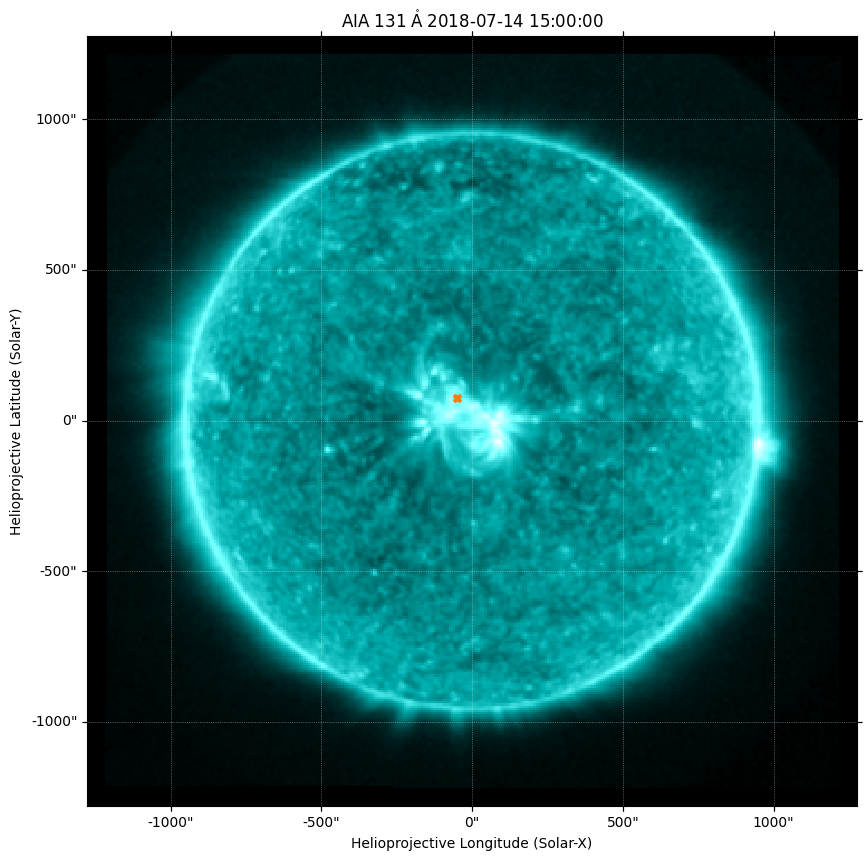

In [40]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection=m)
m.plot(axes=ax)
ax.plot_coord(flare_loc, color='C1', marker='X')

Test convolution of aperture PSF with jitter model

In [62]:
psf_aperture = moxsi_cdr[0].psf

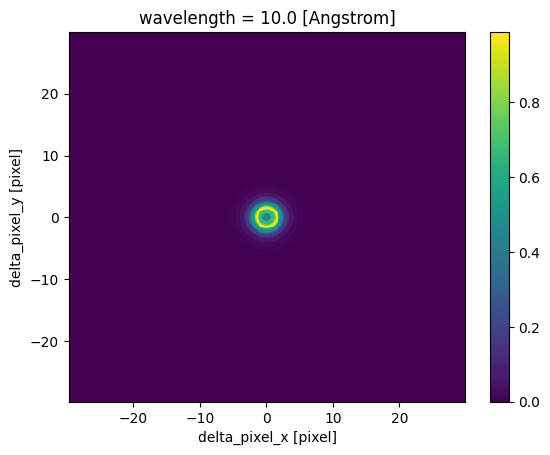

In [65]:
psf_aperture[0].plot(x='delta_pixel_x',y='delta_pixel_y')

In [38]:
from astropy.convolution.kernels import Tophat2DKernel
import astropy.convolution

In [73]:
angular_radius = 30*u.arcsecond

In [74]:
# Assume uniform and same in both directions
det_to_psf_scale = np.diff(psf_aperture.delta_pixel_x)[0]

In [67]:
pointing_jitter_kernel = Tophat2DKernel(
    (angular_radius / moxsi_cdr.optical_design.spatial_plate_scale[0]).to_value('pixel')/det_to_psf_scale)

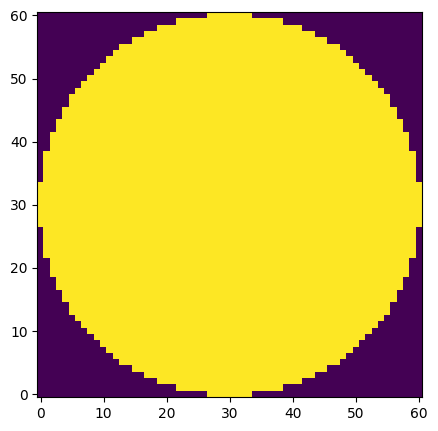

In [68]:
plt.figure(figsize=(5,5))
plt.imshow(pointing_jitter_kernel, origin='lower', interpolation='none')
plt.gca().set_aspect(1)

In [77]:
import xarray

In [91]:
moxsi_cdr[-1].psf.chunks

((1, 1, 1, 1), (418,), (418,))

In [92]:
import dask.array

In [94]:
new_psf_data = []
for _psf in moxsi_cdr[-1].psf:
    _psf_conv = astropy.convolution.convolve(_psf.data, pointing_jitter_kernel)
    new_psf_data.append(_psf_conv)
new_psf_data = np.array(new_psf_data)
psf_aperture_jitter = xarray.DataArray(
    data=dask.array.from_array(new_psf_data, chunks=moxsi_cdr[-1].psf.chunks),
    coords=psf_aperture.coords,
)

In [97]:
moxsi_cdr[-1].psf

<xarray.DataArray (wavelength: 4, y: 418, x: 418)>
dask.array<open_dataset-__xarray_dataarray_variable__, shape=(4, 418, 418), dtype=float64, chunksize=(1, 418, 418), chunktype=numpy.ndarray>
Coordinates:
  * x              (x) float64 -207.9 -206.9 -205.9 -204.9 ... 207.1 208.1 209.1
  * y              (y) float64 -207.9 -206.9 -205.9 -204.9 ... 207.1 208.1 209.1
    delta_pixel_x  (x) float64 dask.array<chunksize=(418,), meta=np.ndarray>
    delta_pixel_y  (y) float64 dask.array<chunksize=(418,), meta=np.ndarray>
  * wavelength     (wavelength) float64 10.0 25.0 50.0 75.0

In [96]:
psf_aperture_jitter

<xarray.DataArray 'array-2bb1e470f4fa62f2593dffd5cb9a2fa1' (wavelength: 4,
                                                            y: 418, x: 418)>
dask.array<array, shape=(4, 418, 418), dtype=float64, chunksize=(1, 418, 418), chunktype=numpy.ndarray>
Coordinates:
  * x              (x) float64 -207.8 -206.8 -205.8 -204.8 ... 207.2 208.2 209.2
  * y              (y) float64 -207.8 -206.8 -205.8 -204.8 ... 207.2 208.2 209.2
    delta_pixel_x  (x) float64 dask.array<chunksize=(418,), meta=np.ndarray>
    delta_pixel_y  (y) float64 dask.array<chunksize=(418,), meta=np.ndarray>
  * wavelength     (wavelength) float64 10.0 25.0 50.0 75.0

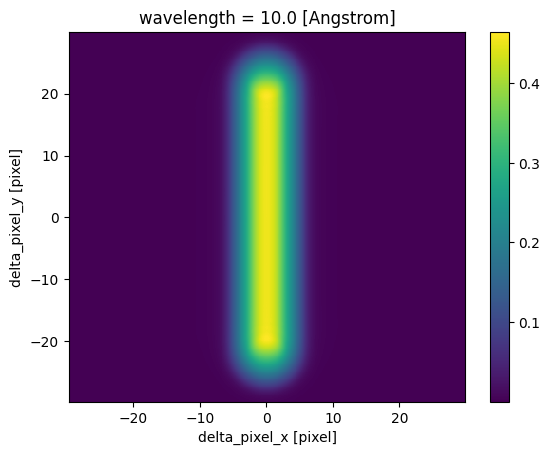

In [87]:
psf_aperture_jitter[0].plot(x='delta_pixel_x',y='delta_pixel_y')

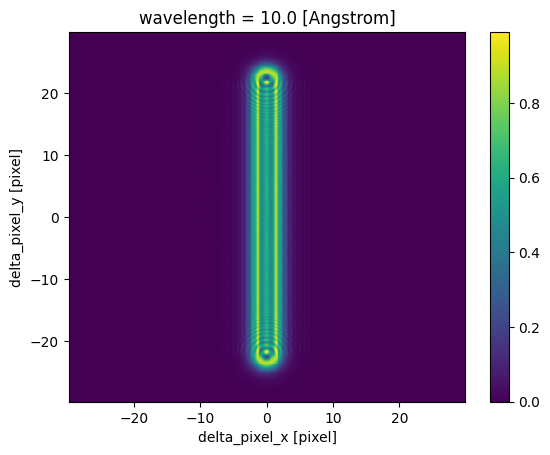

In [88]:
moxsi_cdr[-1].psf[0].plot(x='delta_pixel_x',y='delta_pixel_y')

In [71]:
psf_aperture_jitter = astropy.convolution.convolve(psf_aperture[0].data, pointing_jitter_kernel)

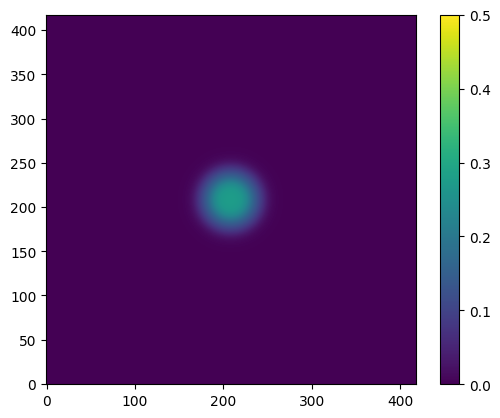

In [72]:
plt.imshow(psf_aperture_jitter,origin='lower', vmin=0, vmax=0.5)
plt.colorbar()

In [121]:
from astropy.utils.data import get_pkg_data_path

In [122]:
get_pkg_data_path('data', package='mocksipipeline.instrument.optics')

'/Users/wtbarnes/Documents/codes/mocksipipeline/mocksipipeline/instrument/optics/data'

In [132]:
moxsi_cdr[0].aperture.__class__.__name__

'CircularAperture'

In [133]:
if (foo := 'foo'+'bar').split():
    print(foo)

foobar
